# Importation de fonctions from cookie_clusters

In [1]:
from cookie_clusters import *

# Trying the algo over some selected pixels

### Creation of the data_set

In [12]:
from selection_pixels_dtw import *
import os
import cv2
from PIL import Image
import rasterio as rio
import re
import matplotlib.pyplot as plt

In [8]:
# List of target pixels
pixels_de_interet = pix_danone + pix_agri + pix_ensta + pix_apt + pix_lac + pix_foret
len(pixels_de_interet)

54

In [75]:
pixels_de_interet[-1]

[488, 570]

In [10]:
# dir = "../../ressources/images"
# images_list = os.listdir(dir)
# with rio.open(dir+'/crop_SENTINEL2A_20151226-111142-750_L2A_T31UDQ_D_V1-1.tif', 'r') as ds:
#     band3 = ds.read(3)
# print(band3.shape)
# lista = list()
# for pixel in pixels_de_interet:
#     lista.append(band3[pixel[0], pixel[1]])
# print(len(lista))

### On divise les images Sentinel 2A et 2B et on les mets en ordre cronologique

In [48]:
dir = "../../ressources/images"
images_list = os.listdir(dir)

images_2A = list()
images_2B = list()
prog = re.compile(r'\w+2A')
for image in images_list:
    if prog.match(image):
        images_2A.append(image)
    else:
        images_2B.append(image)
        
images_2A.sort()
images_2B.sort()
all_images = images_2A + images_2B
all_images = sorted(all_images, key=lambda date: date[16:24])      

In [76]:
list_to_use = all_images
line = 0
matrice = np.zeros((len(pixels_de_interet), len(list_to_use)))
for image in list_to_use:
    with rio.open(dir+'/'+image, 'r') as ds:
        # arr = ds.read()
        # band1 = raster.read(1)
        # band2 = raster.read(2)
        band3 = ds.read(3)
        # band4 = raster.read(4)
    # Extraction of target pixels
    for pixel,j in zip(pixels_de_interet, range(len(pixels_de_interet))):
        matrice[j,line] = band3[pixel[0], pixel[1]]
    line +=1
        

(54, 141)


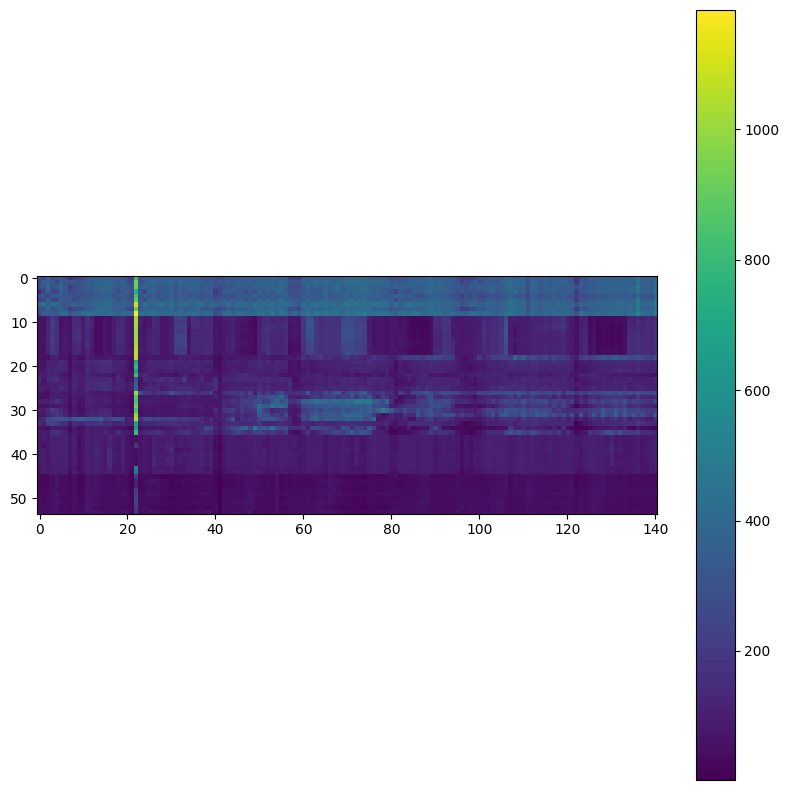

In [77]:
print(matrice.shape)
#Looking for a pixels
img = (matrice/8).astype(int)
#grayImage = cv2.cvtColor(uint_img, cv2.COLOR_GRAY2BGR)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.colorbar()
plt.show()


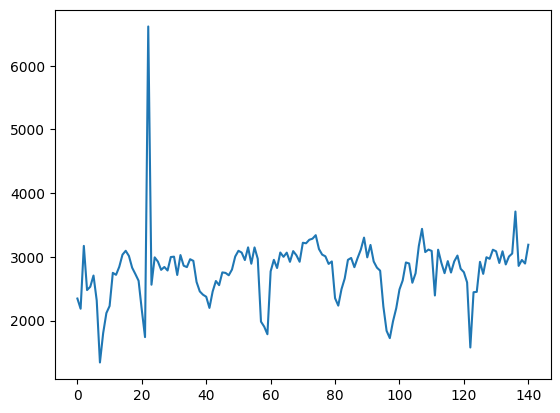

In [78]:
# L'image x est bizarre
plt.plot(matrice[0])

In [79]:
chelou = np.argmax(matrice[0])
chelou

22

In [80]:
matrice = np.delete(matrice,chelou,1)

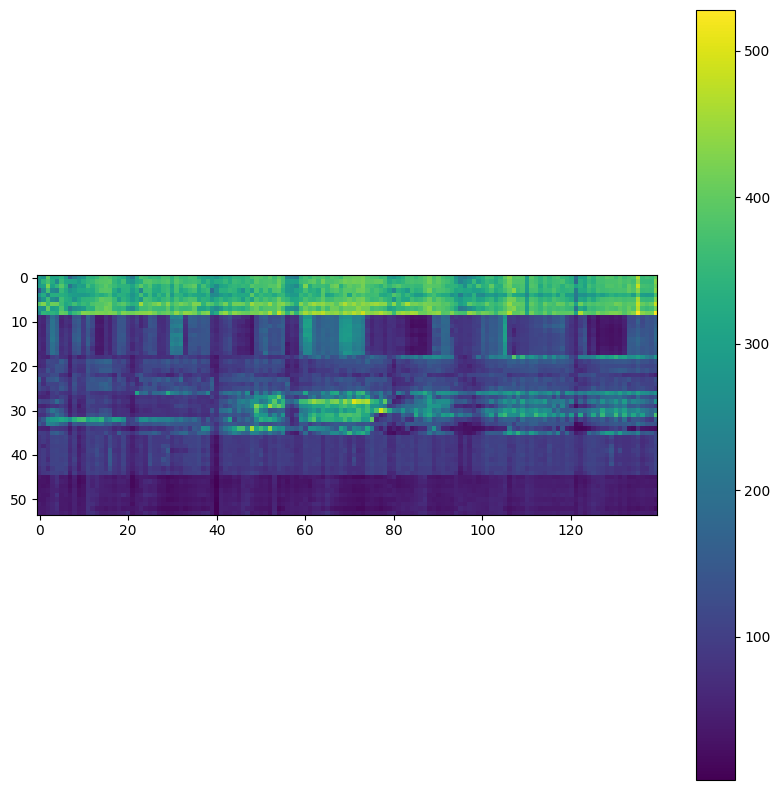

In [81]:
#Looking for a pixels
img = (matrice/8).astype(int)
#grayImage = cv2.cvtColor(uint_img, cv2.COLOR_GRAY2BGR)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.colorbar()
plt.show()


In [83]:
yhat = kmeans_dtw(matrice,6,5000)

In [84]:
len(pix_ensta)

9

In [85]:
print(len(yhat))
yhat

54


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 3, 3, 3,
       4, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 3, 1, 5, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## A simple function to show the obtained results

In [86]:
import collections
def affichage(yhat,pix_interet):
    name = ''
    dico = collections.Counter(yhat)
    for key in list(dico.keys()):
        dico[key] = [f'number of vectors = {dico[key]}'] 
        for index,pos in zip(yhat,range(len(yhat))):
            if index == key:
                if 0<=pos<=8: name = 'pix_danone'
                elif 9<=pos<=17: name = 'pix_agri'
                elif 18<=pos<=26: name = 'pix_ensta'
                elif 27<=pos<=35: name = 'pix_apt'
                elif 36<=pos<=44: name = 'pix_lac'
                elif 45<=pos<=53: name = 'pix_foret'

                dico[key].append(f'{pix_interet[pos]}:{name}')

    for key in dico:
        print(f'cluster numero {key}:\n-------------------------------')
        for part in dico[key]:
            print(f'{part}')
        print('-------------------------------')



In [87]:
affichage(yhat,pixels_de_interet)

cluster numero 2:
-------------------------------
number of vectors = 9
[383, 497]:pix_danone
[383, 500]:pix_danone
[387, 501]:pix_danone
[383, 504]:pix_danone
[387, 505]:pix_danone
[384, 508]:pix_danone
[388, 509]:pix_danone
[384, 504]:pix_danone
[386, 504]:pix_danone
-------------------------------
cluster numero 1:
-------------------------------
number of vectors = 10
[318, 438]:pix_agri
[322, 435]:pix_agri
[324, 433]:pix_agri
[329, 429]:pix_agri
[333, 426]:pix_agri
[337, 424]:pix_agri
[339, 422]:pix_agri
[344, 418]:pix_agri
[350, 414]:pix_agri
[420, 458]:pix_apt
-------------------------------
cluster numero 5:
-------------------------------
number of vectors = 9
[447, 618]:pix_ensta
[433, 617]:pix_ensta
[405, 448]:pix_apt
[408, 444]:pix_apt
[412, 446]:pix_apt
[412, 463]:pix_apt
[407, 465]:pix_apt
[405, 455]:pix_apt
[401, 446]:pix_apt
-------------------------------
cluster numero 3:
-------------------------------
number of vectors = 7
[454, 627]:pix_ensta
[454, 631]:pix_ensta
[

## En repetant la meme tache avec le NDVI

In [93]:
list_to_use = all_images
line = 0
matrice = np.zeros((len(pixels_de_interet), len(list_to_use)))
for image in list_to_use:
    with rio.open(dir+'/'+image, 'r') as ds:
        # arr = ds.read()
        band1 = ds.read(1)
        band2 = ds.read(2)
        ndvi = (band1-band2)/(band1+band2)
        # band3 = ds.read(3)
        # band4 = ds.read(4)
    # Extraction of target pixels
    for pixel,j in zip(pixels_de_interet, range(len(pixels_de_interet))):
        matrice[j,line] = ndvi[pixel[0], pixel[1]]
    line +=1



/tmp/ipykernel_1270/3564424484.py:9: RuntimeWarning: invalid value encountered in divide
  ndvi = (band1-band2)/(band1+band2)


(54, 141)


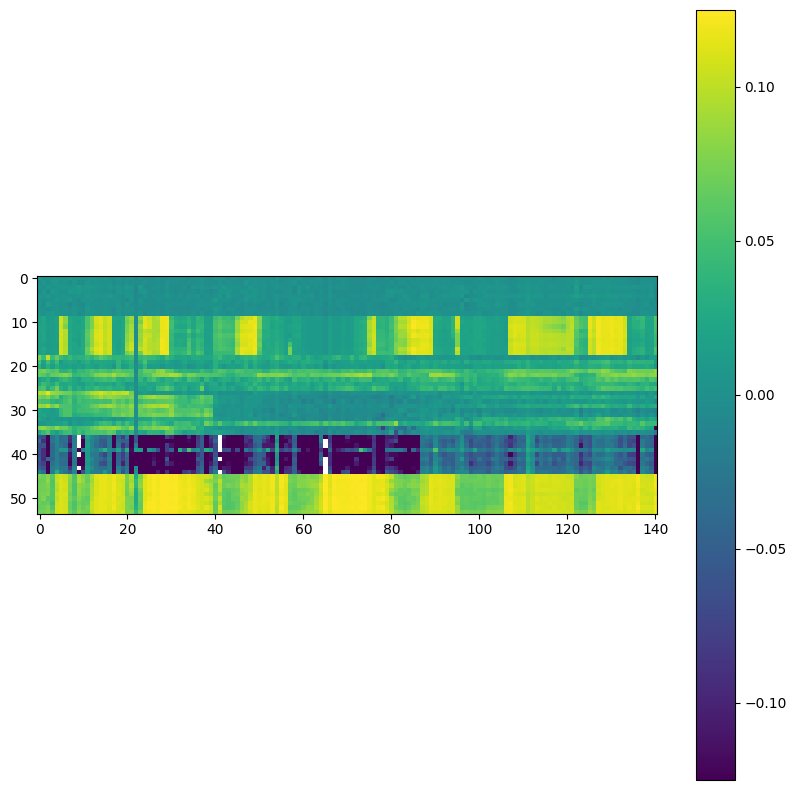

In [94]:
print(matrice.shape)
#Looking for a pixels
img = (matrice/8)
#grayImage = cv2.cvtColor(uint_img, cv2.COLOR_GRAY2BGR)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.colorbar()
plt.show()